# Exploration: KL Divergence Between Small and Large Models

This notebook explores the distributional differences between small and large models on the Pile dataset. We compute per-token KL divergence to identify where the models diverge most significantly.

**Goal**: Understand baseline differences between small and large models before investigating user-modeling specific behaviors.

## What we're doing:
1. Load two models from the same family (Gemma-2-2B and Gemma-2-9B)
2. Run both on the same text documents
3. At each token position, compare their next-token predictions
4. Measure KL divergence - how much do they disagree?
5. Analyze where and why they differ

## Setup & Imports

In [77]:
# Install dependencies if needed (uncomment if running fresh)
# !pip install torch transformer-lens datasets pandas numpy tqdm matplotlib

In [78]:
import torch
import torch.nn.functional as F
from transformer_lens import HookedTransformer
from datasets import load_dataset
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from pathlib import Path
import gc
import matplotlib.pyplot as plt

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.9.1+cu128
CUDA available: True


## CUDA Check

Verify GPU is available and print device info.

In [79]:
def enforce_cuda():
    """Ensure CUDA is available and being used."""
    if not torch.cuda.is_available():
        print("WARNING: CUDA is not available! Running on CPU will be very slow.")
        return "cpu"

    print("=" * 60)
    print("GPU CONFIGURATION")
    print("=" * 60)
    print(f"PyTorch version: {torch.__version__}")
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    print(f"Current memory allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
    print("=" * 60)

    return "cuda"

DEVICE = enforce_cuda()

GPU CONFIGURATION
PyTorch version: 2.9.1+cu128
CUDA version: 12.8
GPU: NVIDIA GeForce RTX 3080
GPU Memory: 10.7 GB
Current memory allocated: 0.01 GB


## Configuration

Set up which models to compare and how much data to process.

In [80]:
# Model configuration - TransformerLens model names
# Using Pythia models (ungated, no HF login required, smaller for testing)
SMALL_MODEL_NAME = "pythia-410m"
BIG_MODEL_NAME = "pythia-1.4b"

# Alternative: Gemma models (require HF login with gated repo access)
# WARNING: gemma-2-9b is ~18GB, won't fit on 10GB VRAM with 2b loaded
# SMALL_MODEL_NAME = "gemma-2-2b"
# BIG_MODEL_NAME = "gemma-2-9b"

# Dataset configuration
DATASET_NAME = "NeelNanda/pile-10k"   # 10k subset of the Pile
MAX_TOKENS = 500                       # Max tokens per document
NUM_DOCUMENTS = 100                    # Set to None for all 10k documents

# Processing configuration
CONTEXT_WINDOW = 5                     # Tokens before/after for context display

# Output paths
OUTPUT_DIR = Path("../results")
FIGURES_DIR = Path("../figures")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print(f"Small model: {SMALL_MODEL_NAME}")
print(f"Big model: {BIG_MODEL_NAME}")
print(f"Documents to process: {NUM_DOCUMENTS}")
print(f"Max tokens per doc: {MAX_TOKENS}")

Small model: pythia-410m
Big model: pythia-1.4b
Documents to process: 100
Max tokens per doc: 500


## Load Small Model

Load the smaller Gemma model using TransformerLens. This gives us hooks into model internals for interpretability work later.

In [81]:
print(f"Loading {SMALL_MODEL_NAME} with TransformerLens...")

small_model = HookedTransformer.from_pretrained(
    SMALL_MODEL_NAME,
    torch_dtype=torch.bfloat16,
    device=DEVICE,
)

print(f"✓ Loaded {SMALL_MODEL_NAME}")
print(f"  Parameters: {small_model.cfg.n_params / 1e6:.0f}M")
print(f"  Layers: {small_model.cfg.n_layers}")
print(f"  GPU Memory used: {torch.cuda.memory_allocated() / 1e9:.2f} GB")

Loading pythia-410m with TransformerLens...


Loaded pretrained model pythia-410m into HookedTransformer
✓ Loaded pythia-410m
  Parameters: 302M
  Layers: 24
  GPU Memory used: 0.92 GB


## Load Big Model

Load the larger Gemma model. Same architecture, more parameters = more capacity.

In [82]:
print(f"Loading {BIG_MODEL_NAME} with TransformerLens...")

big_model = HookedTransformer.from_pretrained(
    BIG_MODEL_NAME,
    torch_dtype=torch.bfloat16,
    device=DEVICE,
)

print(f"✓ Loaded {BIG_MODEL_NAME}")
print(f"  Parameters: {big_model.cfg.n_params / 1e6:.0f}M")
print(f"  Layers: {big_model.cfg.n_layers}")
print(f"  GPU Memory used: {torch.cuda.memory_allocated() / 1e9:.2f} GB")

Loading pythia-1.4b with TransformerLens...


Loaded pretrained model pythia-1.4b into HookedTransformer
✓ Loaded pythia-1.4b
  Parameters: 1208M
  Layers: 24
  GPU Memory used: 3.86 GB


## Load Dataset

Load the Pile-10k dataset - 10,000 diverse text documents from The Pile.

In [83]:
print(f"Loading dataset: {DATASET_NAME}")

dataset = load_dataset(DATASET_NAME, split="train")

if NUM_DOCUMENTS is not None:
    dataset = dataset.select(range(min(NUM_DOCUMENTS, len(dataset))))

# Get only the text column
texts = dataset["text"]

print(f"Loaded {len(texts)} documents")

Loading dataset: NeelNanda/pile-10k
Loaded 100 documents


In [84]:
# Preview a sample document
print("Sample document preview:")
print("-" * 60)
print(dataset[0]["text"][:500])
print("-" * 60)

Sample document preview:
------------------------------------------------------------
It is done, and submitted. You can play “Survival of the Tastiest” on Android, and on the web. Playing on the web works, but you have to simulate multi-touch for table moving and that can be a bit confusing.

There’s a lot I’d like to talk about. I’ll go through every topic, insted of making the typical what went right/wrong list.

Concept

Working over the theme was probably one of the hardest tasks I had to face.

Originally, I had an idea of what kind of game I wanted to develop, gameplay wis
------------------------------------------------------------


## Understanding KL Divergence (Beginner-Friendly Explanation)

### What is KL Divergence?

**KL Divergence** (Kullback-Leibler Divergence) measures how different one probability distribution is from another. Think of it as asking: *"How surprised would I be if I thought the world worked like distribution Q, but it actually works like distribution P?"*

---

### A Simple Example: Weather Predictions

Imagine two weather forecasters predicting tomorrow's weather:

| Weather | **Forecaster P** (Expert) | **Forecaster Q** (Beginner) |
|---------|---------------------------|------------------------------|
| Sunny   | 70%                       | 40%                          |
| Rainy   | 20%                       | 40%                          |
| Cloudy  | 10%                       | 20%                          |

**Question**: How "wrong" is Forecaster Q compared to the Expert P?

---

### The Math (Step by Step)

KL Divergence formula:

$$KL(P \| Q) = \sum_{x} P(x) \cdot \log\left(\frac{P(x)}{Q(x)}\right)$$

Or equivalently:

$$KL(P \| Q) = \sum_{x} P(x) \cdot (\log P(x) - \log Q(x))$$

**In plain English**: For each possible outcome, we:
1. Take the probability according to P (the "truth")
2. Multiply by how much P and Q disagree (the log ratio)
3. Sum it all up

---

### Let's Calculate It!

Using our weather example:

```
KL(P || Q) = P(sunny) × log(P(sunny)/Q(sunny))
           + P(rainy) × log(P(rainy)/Q(rainy))
           + P(cloudy) × log(P(cloudy)/Q(cloudy))

           = 0.70 × log(0.70/0.40)
           + 0.20 × log(0.20/0.40)  
           + 0.10 × log(0.10/0.20)

           = 0.70 × log(1.75)
           + 0.20 × log(0.50)
           + 0.10 × log(0.50)

           = 0.70 × 0.56
           + 0.20 × (-0.69)
           + 0.10 × (-0.69)

           = 0.392 - 0.138 - 0.069
           = 0.185 nats
```

---

### What Does This Number Mean?

| KL Value | Interpretation |
|----------|----------------|
| **0**    | P and Q are identical (no divergence) |
| **Small (< 0.1)** | Q is very close to P |
| **Medium (0.1 - 1)** | Q differs noticeably from P |
| **Large (> 1)** | Q is very different from P |

---

### Key Properties of KL Divergence

1. **Always ≥ 0**: KL divergence is never negative
2. **Not symmetric**: KL(P||Q) ≠ KL(Q||P) — it matters which one is "truth"
3. **Zero only when identical**: KL(P||Q) = 0 only if P = Q everywhere

---

### Why Use KL Divergence for Language Models?

When a language model predicts the next token, it outputs a probability distribution over all possible tokens (vocabulary size ~256k for Gemma).

**Example**: After seeing "The cat sat on the", models predict:

| Next Token | **Big Model (P)** | **Small Model (Q)** |
|------------|-------------------|---------------------|
| "mat"      | 35%               | 20%                 |
| "floor"    | 25%               | 25%                 |
| "roof"     | 15%               | 10%                 |
| "chair"    | 10%               | 15%                 |
| "dog"      | 1%                | 10%                 |
| ... (other tokens) | 14%      | 20%                 |

**KL(Big || Small)** tells us: *How much does the small model's prediction differ from the big model's prediction?*

- **High KL**: Models strongly disagree — interesting position!
- **Low KL**: Models mostly agree — boring position

---

### In Our Code

We compute `KL(big_model || small_model)` treating the big model as "ground truth":

```python
# Convert logits to probabilities
log_p = F.log_softmax(big_logits, dim=-1)    # Big model (reference)
log_q = F.log_softmax(small_logits, dim=-1)  # Small model (comparison)

p = torch.exp(log_p)  # Actual probabilities for big model

# KL divergence: sum over vocabulary
kl_div = torch.sum(p * (log_p - log_q), dim=-1)
```

This gives us one KL value per token position, telling us where the models disagree most!

In [85]:
# Interactive Example: Calculate KL Divergence by Hand
# =====================================================
# Let's verify the weather example from above!

import numpy as np

# Weather probabilities
P = np.array([0.70, 0.20, 0.10])  # Expert forecaster (reference/truth)
Q = np.array([0.40, 0.40, 0.20])  # Beginner forecaster (comparison)
labels = ["Sunny", "Rainy", "Cloudy"]

print("=" * 50)
print("WEATHER FORECASTER EXAMPLE")
print("=" * 50)
print("\nProbability distributions:")
for i, label in enumerate(labels):
    print(f"  {label}: P={P[i]:.0%}, Q={Q[i]:.0%}")

# Calculate KL divergence step by step
print("\n" + "=" * 50)
print("KL DIVERGENCE CALCULATION (Step by Step)")
print("=" * 50)

total_kl = 0
for i, label in enumerate(labels):
    # Each term: P(x) * log(P(x) / Q(x))
    term = P[i] * np.log(P[i] / Q[i])
    total_kl += term
    print(f"\n{label}:")
    print(f"  P({label}) × log(P/Q) = {P[i]:.2f} × log({P[i]:.2f}/{Q[i]:.2f})")
    print(f"                        = {P[i]:.2f} × log({P[i]/Q[i]:.2f})")
    print(f"                        = {P[i]:.2f} × {np.log(P[i]/Q[i]):.3f}")
    print(f"                        = {term:.4f}")

print("\n" + "=" * 50)
print(f"TOTAL KL(P || Q) = {total_kl:.4f} nats")
print("=" * 50)

# Interpretation
print("\nInterpretation:")
if total_kl < 0.1:
    print("  → Small divergence: Q is close to P")
elif total_kl < 1.0:
    print("  → Medium divergence: Q differs noticeably from P")
else:
    print("  → Large divergence: Q is very different from P")

# Show that KL is NOT symmetric
kl_qp = np.sum(Q * np.log(Q / P))
print(f"\nNote: KL is NOT symmetric!")
print(f"  KL(P || Q) = {total_kl:.4f}")
print(f"  KL(Q || P) = {kl_qp:.4f}  ← Different!")

WEATHER FORECASTER EXAMPLE

Probability distributions:
  Sunny: P=70%, Q=40%
  Rainy: P=20%, Q=40%
  Cloudy: P=10%, Q=20%

KL DIVERGENCE CALCULATION (Step by Step)

Sunny:
  P(Sunny) × log(P/Q) = 0.70 × log(0.70/0.40)
                        = 0.70 × log(1.75)
                        = 0.70 × 0.560
                        = 0.3917

Rainy:
  P(Rainy) × log(P/Q) = 0.20 × log(0.20/0.40)
                        = 0.20 × log(0.50)
                        = 0.20 × -0.693
                        = -0.1386

Cloudy:
  P(Cloudy) × log(P/Q) = 0.10 × log(0.10/0.20)
                        = 0.10 × log(0.50)
                        = 0.10 × -0.693
                        = -0.0693

TOTAL KL(P || Q) = 0.1838 nats

Interpretation:
  → Medium divergence: Q differs noticeably from P

Note: KL is NOT symmetric!
  KL(P || Q) = 0.1838
  KL(Q || P) = 0.1920  ← Different!


In [86]:
def compute_kl_divergence(logits_p: torch.Tensor, logits_q: torch.Tensor) -> torch.Tensor:
    """
    Compute KL divergence: KL(P || Q) where P is the "true" distribution.

    Here we compute KL(big_model || small_model) to see where small model
    diverges from big model's predictions.
    
    Args:
        logits_p: Logits from reference model (big) [seq_len, vocab_size]
        logits_q: Logits from comparison model (small) [seq_len, vocab_size]
    
    Returns:
        kl_div: Per-token KL divergence [seq_len]
    """
    # Convert to log probabilities (float32 for numerical stability)
    log_p = F.log_softmax(logits_p.float(), dim=-1)
    log_q = F.log_softmax(logits_q.float(), dim=-1)

    # Compute probabilities for P
    p = torch.exp(log_p)

    # KL(P || Q) = sum(P * (log P - log Q))
    kl_div = torch.sum(p * (log_p - log_q), dim=-1)

    return kl_div

print("✓ KL divergence function defined")

✓ KL divergence function defined


In [87]:
def get_context_text(tokens: list, position: int, model, window: int = 5) -> tuple:
    """Get the text context around a token position."""
    seq_len = len(tokens)

    start_before = max(0, position - window)
    end_after = min(seq_len, position + window + 1)

    before_tokens = tokens[start_before:position+1]
    after_tokens = tokens[position + 1:end_after]

    before_text = model.tokenizer.decode(before_tokens, skip_special_tokens=True)
    after_text = model.tokenizer.decode(after_tokens, skip_special_tokens=True)

    return before_text, after_text

print("✓ Context extraction function defined")

✓ Context extraction function defined


### Document Processing

For each document, we:
1. Tokenize the text
2. Run both models to get their predictions at each position
3. Compute KL divergence between their distributions
4. Record the actual next token and each model's confidence in it

In [88]:
@torch.no_grad()
def process_document(
    text: str,
    small_model: HookedTransformer,
    big_model: HookedTransformer,
    max_tokens: int = 500,
    context_window: int = 5
) -> list:
    """
    Process a single document and compute per-token KL divergence.
    
    Returns a list of dicts, one per token position.
    """
    # Tokenize
    tokens = small_model.to_tokens(text, truncate=True)

    # Truncate if needed
    if tokens.shape[1] > max_tokens:
        tokens = tokens[:, :max_tokens]

    seq_len = tokens.shape[1]

    if seq_len < 2:
        return []

    # Get logits from both models
    # Shape: [batch=1, seq_len, vocab_size]
    small_logits = small_model(tokens)[0]  # Remove batch dim
    big_logits = big_model(tokens)[0]

    # Compute KL divergence: KL(big || small)
    kl_divs = compute_kl_divergence(big_logits, small_logits)

    # Get log probabilities for actual next tokens
    token_list = tokens[0].cpu().tolist()
    small_log_probs = F.log_softmax(small_logits.float(), dim=-1)
    big_log_probs = F.log_softmax(big_logits.float(), dim=-1)

    results = []

    # For each position (except last, since we need next token)
    for pos in range(seq_len - 1):
        next_token_id = token_list[pos + 1]
        current_token_id = token_list[pos]

        # Log prob of actual next token under each model
        small_log_prob = small_log_probs[pos, next_token_id].item()
        big_log_prob = big_log_probs[pos, next_token_id].item()

        # Get surrounding context for display
        before_text, after_text = get_context_text(token_list, pos, small_model, context_window)

        results.append({
            "position": pos,
            "token_id": current_token_id,
            "token_text": small_model.tokenizer.decode([current_token_id]),
            "next_token_id": next_token_id,
            "next_token_text": small_model.tokenizer.decode([next_token_id]),
            "kl_divergence": kl_divs[pos].item(),
            "small_log_prob": small_log_prob,
            "big_log_prob": big_log_prob,
            "log_prob_diff": big_log_prob - small_log_prob,
            "context_before": before_text,
            "context_after": after_text,
        })

    return results

print("✓ Document processing function defined")

✓ Document processing function defined


## Process Dataset

Now we run both models on all documents and collect the results.

In [89]:
print(f"Processing {len(texts)} documents with max {MAX_TOKENS} tokens each...")
print("This may take a few minutes...\n")

all_results = []

for batch_idx, text in enumerate(tqdm(texts, desc="Processing documents")):
    try:
        doc_results = process_document(
            text,
            small_model,
            big_model,
            max_tokens=MAX_TOKENS,
            context_window=CONTEXT_WINDOW
        )

        # Add document index to each result
        for result in doc_results:
            result["batch_idx"] = batch_idx

        all_results.extend(doc_results)

    except Exception as e:
        print(f"Error processing document {batch_idx}: {e}")
        continue

    # Clear GPU cache periodically
    if batch_idx % 100 == 0:
        torch.cuda.empty_cache()

print(f"\n Processed {len(all_results):,} tokens total")

Processing 100 documents with max 500 tokens each...
This may take a few minutes...



Processing documents: 100%|██████████| 100/100 [00:21<00:00,  4.72it/s]


 Processed 34,965 tokens total


In [90]:
# Create DataFrame
df = pd.DataFrame(all_results)

# Reorder columns for clarity
column_order = [
    "batch_idx", "position", "token_id", "token_text",
    "next_token_id", "next_token_text", "kl_divergence",
    "small_log_prob", "big_log_prob", "log_prob_diff",
    "context_before", "context_after",
]
df = df[column_order]

print(f"DataFrame shape: {df.shape}")
df.head(10)

DataFrame shape: (34965, 12)


,batch_idx,position,token_id,token_text,next_token_id,next_token_text,kl_divergence,small_log_prob,big_log_prob,log_prob_diff,context_before,context_after
0,0,0,0,<|endoftext|>,1147,It,0.174900,-5.445971,-5.415972,0.029999,,"It is done, and"
1,0,1,1147,It,310,is,0.031592,-1.523000,-1.416713,0.106287,It,"is done, and submitted"
2,0,2,310,is,2218,done,0.174099,-7.811517,-8.999162,-1.187645,It is,"done, and submitted."
3,0,3,2218,done,13,",",0.196236,-2.488600,-2.307228,0.181373,It is done,", and submitted. You"
4,0,4,13,",",285,and,0.358531,-2.650959,-2.015814,0.635145,"It is done,",and submitted. You can
5,0,5,285,and,9262,submitted,0.130651,-9.912782,-11.221546,-1.308764,"It is done, and",submitted. You can play
6,0,6,9262,submitted,15,.,0.131565,-1.484264,-1.675797,-0.191533,"It is done, and submitted",. You can play “
7,0,7,15,.,1422,You,0.383958,-4.096498,-4.735905,-0.639406,"is done, and submitted.",You can play “Sur
8,0,8,1422,You,476,can,0.142437,-1.104162,-1.053258,0.050904,"done, and submitted. You",can play “Survival
9,0,9,476,can,1132,play,0.360403,-6.608739,-5.732753,0.875986,", and submitted. You can",play “Survival of


## Understanding the Results

### Column Breakdown

| Column | Meaning |
|--------|---------|
| `batch_idx` | Which document (0-99) |
| `position` | Token position in sequence |
| `token_text` | Current token at this position |
| `next_token_text` | The actual next token in the document |
| `kl_divergence` | How much the models disagree at this position (in nats) |
| `small_log_prob` | Small model's log probability for the actual next token |
| `big_log_prob` | Big model's log probability for the actual next token |
| `log_prob_diff` | `big - small` (positive = big model more confident on actual token) |

### How to Interpret

**KL Divergence** measures *total distribution* disagreement across all possible next tokens. High KL means the models have fundamentally different beliefs about what comes next.

**Log Prob Diff** only shows disagreement on the *actual* next token that appeared. 

**Key insight**: High KL with small log_prob_diff means models disagree about alternatives but agree on what actually happened. High KL with large log_prob_diff means models fundamentally disagree, and one was more "right" about the actual continuation.

### Example Interpretation

If you see:
- KL = 0.35, log_prob_diff = +0.6 → Models disagree, big model was more confident on actual next token
- KL = 0.13, log_prob_diff = -1.3 → Models somewhat agree overall, but small model was more confident on actual next token (got "lucky" or has different priors)
- KL = 2.0, log_prob_diff = 0.0 → Models strongly disagree about distribution, but happened to agree on this particular token

## Save Results

In [91]:
parquet_path = OUTPUT_DIR / "kl_divergence_results.parquet"
csv_path = OUTPUT_DIR / "kl_divergence_results.csv"

df.to_parquet(parquet_path, index=False)
print(f"✓ Saved {parquet_path}")

df.to_csv(csv_path, index=False)
print(f"✓ Saved {csv_path}")

✓ Saved ..\results\kl_divergence_results.parquet
✓ Saved ..\results\kl_divergence_results.csv


## Analysis: Statistics

Let's look at the distribution of KL divergence values.

In [92]:
print("=" * 60)
print("KL DIVERGENCE STATISTICS")
print("=" * 60)
print(f"\nTotal tokens analyzed: {len(df):,}")
print(f"Documents processed: {df['batch_idx'].nunique()}")
print(f"\nKL Divergence (KL(big || small)):")
print(df["kl_divergence"].describe())

KL DIVERGENCE STATISTICS

Total tokens analyzed: 34,965
Documents processed: 100

KL Divergence (KL(big || small)):
count    34965.000000
mean         0.313896
std          0.423470
min          0.000001
25%          0.066562
50%          0.197934
75%          0.405887
max         12.632759
Name: kl_divergence, dtype: float64


In [93]:
# Percentiles
print("\nKL Divergence Percentiles:")
for p in [50, 75, 90, 95, 99, 99.9]:
    val = df["kl_divergence"].quantile(p/100)
    print(f"  {p}th percentile: {val:.4f}")


KL Divergence Percentiles:
  50th percentile: 0.1979
  75th percentile: 0.4059
  90th percentile: 0.7062
  95th percentile: 0.9944
  99th percentile: 2.0127
  99.9th percentile: 4.2055


## Analysis: Top Divergent Tokens

Where do the models disagree the most? These are the most "interesting" positions.

In [94]:
print("=" * 60)
print("TOP 20 MOST DIVERGENT TOKENS")
print("=" * 60)

top_divergent = df.nlargest(20, "kl_divergence")[
    ["batch_idx", "position", "token_text", "next_token_text",
     "kl_divergence", "context_before", "context_after"]
]

for idx, row in top_divergent.iterrows():
    print(f"\nKL: {row['kl_divergence']:.4f}")
    print(f"  Context: ...{row['context_before']}[{row['token_text']}]{row['context_after']}...")
    print(f"  Next token: '{row['next_token_text']}'")
    print(f"  Doc: {row['batch_idx']}, Pos: {row['position']}")

TOP 20 MOST DIVERGENT TOKENS

KL: 12.6328
  Context: ...ormorant-sc"["] do
  version :...
  Next token: ' do'
  Doc: 98, Pos: 12

KL: 9.4422
  Context: ... Miami Heat. Join Cowbell[bell] Kingdom’sJames Ham...
  Next token: ' Kingdom'
  Doc: 72, Pos: 120

KL: 7.1558
  Context: ...ers wrtier Sam Inkers[kers]ole, where he will...
  Next token: 'ole'
  Doc: 15, Pos: 304

KL: 6.5571
  Context: ...orantsc",
      [      ]using:      :sv...
  Next token: 'using'
  Doc: 98, Pos: 75

KL: 6.4333
  Context: ...
This file is generated by[ by] Workflow compiler
https...
  Next token: ' Work'
  Doc: 86, Pos: 32

KL: 6.3604
  Context: ... it is possible to superbroad[road]cast/ teleport the...
  Next token: 'cast'
  Doc: 22, Pos: 169

KL: 6.1647
  Context: ... Caption DNAinfo/Katie[atie] Honan

J...
  Next token: ' Hon'
  Doc: 46, Pos: 23

KL: 6.1293
  Context: ... re:Invent Midnight[night] Madness event. Amazon...
  Next token: ' Mad'
  Doc: 3, Pos: 22

KL: 5.6730
  Context: ... enum type represents

In [95]:
# Show as table
top_divergent

,batch_idx,position,token_text,next_token_text,kl_divergence,context_before,context_after
34274,98,12,"""",do,12.632759,"ormorant-sc""",do\n version :
24977,72,120,bell,Kingdom,9.442186,Miami Heat. Join Cowbell,Kingdom’sJames Ham
5360,15,304,kers,ole,7.155758,ers wrtier Sam Inkers,"ole, where he will"
34337,98,75,,using,6.557114,"orantsc"",\n",using: :sv
30018,86,32,by,Work,6.433273,\nThis file is generated by,Workflow compiler\nhttps
7496,22,169,road,cast,6.360390,it is possible to superbroad,cast/ teleport the
15873,46,23,atie,Hon,6.164677,Caption DNAinfo/Katie,Honan\n\nJ
1285,3,22,night,Mad,6.129349,re:Invent Midnight,Madness event. Amazon
24318,68,223,///,possible,5.673010,enum type represents the\n///,possible tag states with which
11601,36,60,Th,omb,5.465069,ata and Prarthana Th,ombare won the title


## Visualization: KL Divergence Distribution

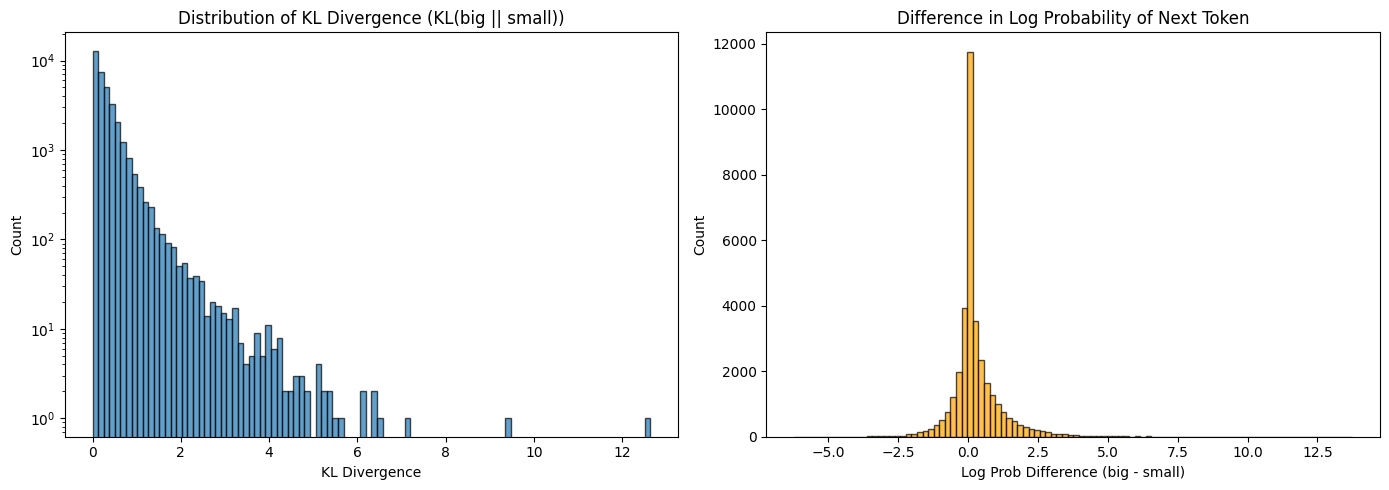

In [96]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# KL Divergence histogram
axes[0].hist(df["kl_divergence"], bins=100, edgecolor="black", alpha=0.7)
axes[0].set_xlabel("KL Divergence")
axes[0].set_ylabel("Count")
axes[0].set_title("Distribution of KL Divergence (KL(big || small))")
axes[0].set_yscale("log")

# Log prob difference histogram
axes[1].hist(df["log_prob_diff"], bins=100, edgecolor="black", alpha=0.7, color="orange")
axes[1].set_xlabel("Log Prob Difference (big - small)")
axes[1].set_ylabel("Count")
axes[1].set_title("Difference in Log Probability of Next Token")

plt.tight_layout()
plt.savefig(FIGURES_DIR / "kl_divergence_distribution.png", dpi=150)
plt.show()

## Visualization: KL by Position

Does KL divergence change as we go deeper into the document?

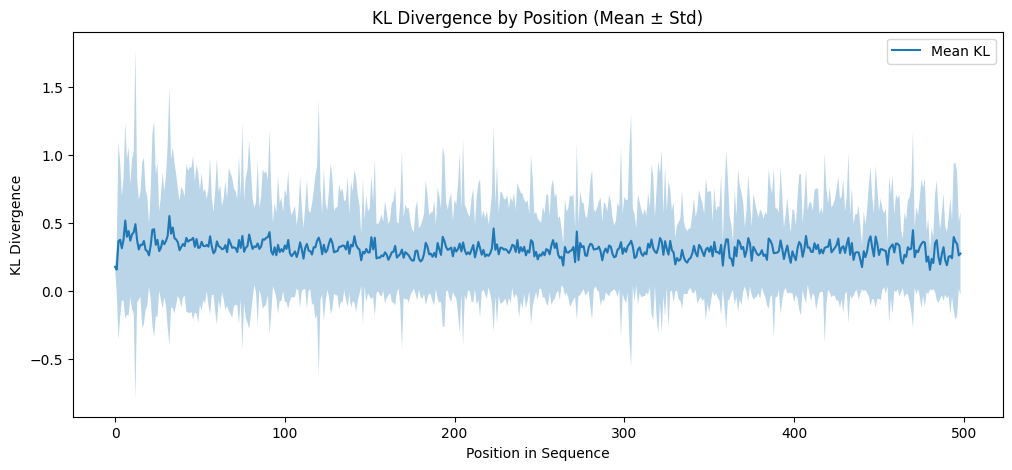

In [97]:
position_stats = df.groupby("position")["kl_divergence"].agg(["mean", "std", "median"]).reset_index()

plt.figure(figsize=(12, 5))
plt.plot(position_stats["position"], position_stats["mean"], label="Mean KL")
plt.fill_between(
    position_stats["position"],
    position_stats["mean"] - position_stats["std"],
    position_stats["mean"] + position_stats["std"],
    alpha=0.3
)
plt.xlabel("Position in Sequence")
plt.ylabel("KL Divergence")
plt.title("KL Divergence by Position (Mean ± Std)")
plt.legend()
plt.savefig(FIGURES_DIR / "kl_by_position.png", dpi=150)
plt.show()

## Visualization: KL vs Log Prob Difference

Is high KL divergence correlated with the big model being more confident?

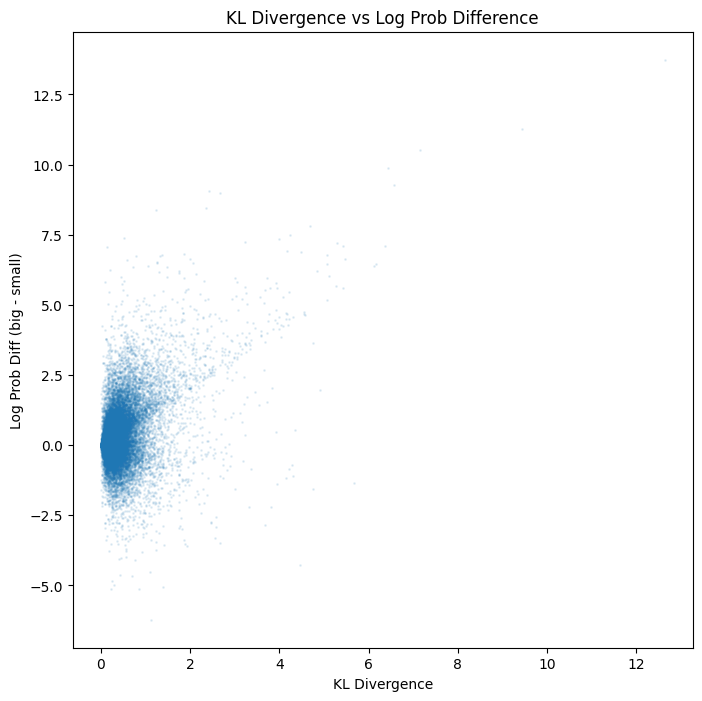

Correlation (KL vs log_prob_diff): 0.4239


In [98]:
plt.figure(figsize=(8, 8))
plt.scatter(df["kl_divergence"], df["log_prob_diff"], alpha=0.1, s=1)
plt.xlabel("KL Divergence")
plt.ylabel("Log Prob Diff (big - small)")
plt.title("KL Divergence vs Log Prob Difference")
plt.savefig(FIGURES_DIR / "kl_vs_logprob.png", dpi=150)
plt.show()

correlation = df["kl_divergence"].corr(df["log_prob_diff"])
print(f"Correlation (KL vs log_prob_diff): {correlation:.4f}")

## Visualization: KL Divergence Deep Dive

Four views to understand how model divergence varies:
1. **Line traces** for low/medium/high KL documents - see how divergence fluctuates within documents
2. **2D density plot** - where do most tokens fall in position vs KL space?
3. **Smoothed trend** - does KL systematically change with position?
4. **Box plots** - distribution of KL across position ranges

C:\Users\dcani\AppData\Local\Temp\ipykernel_430720\878484707.py:52: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(box_data, labels=position_labels, patch_artist=True)


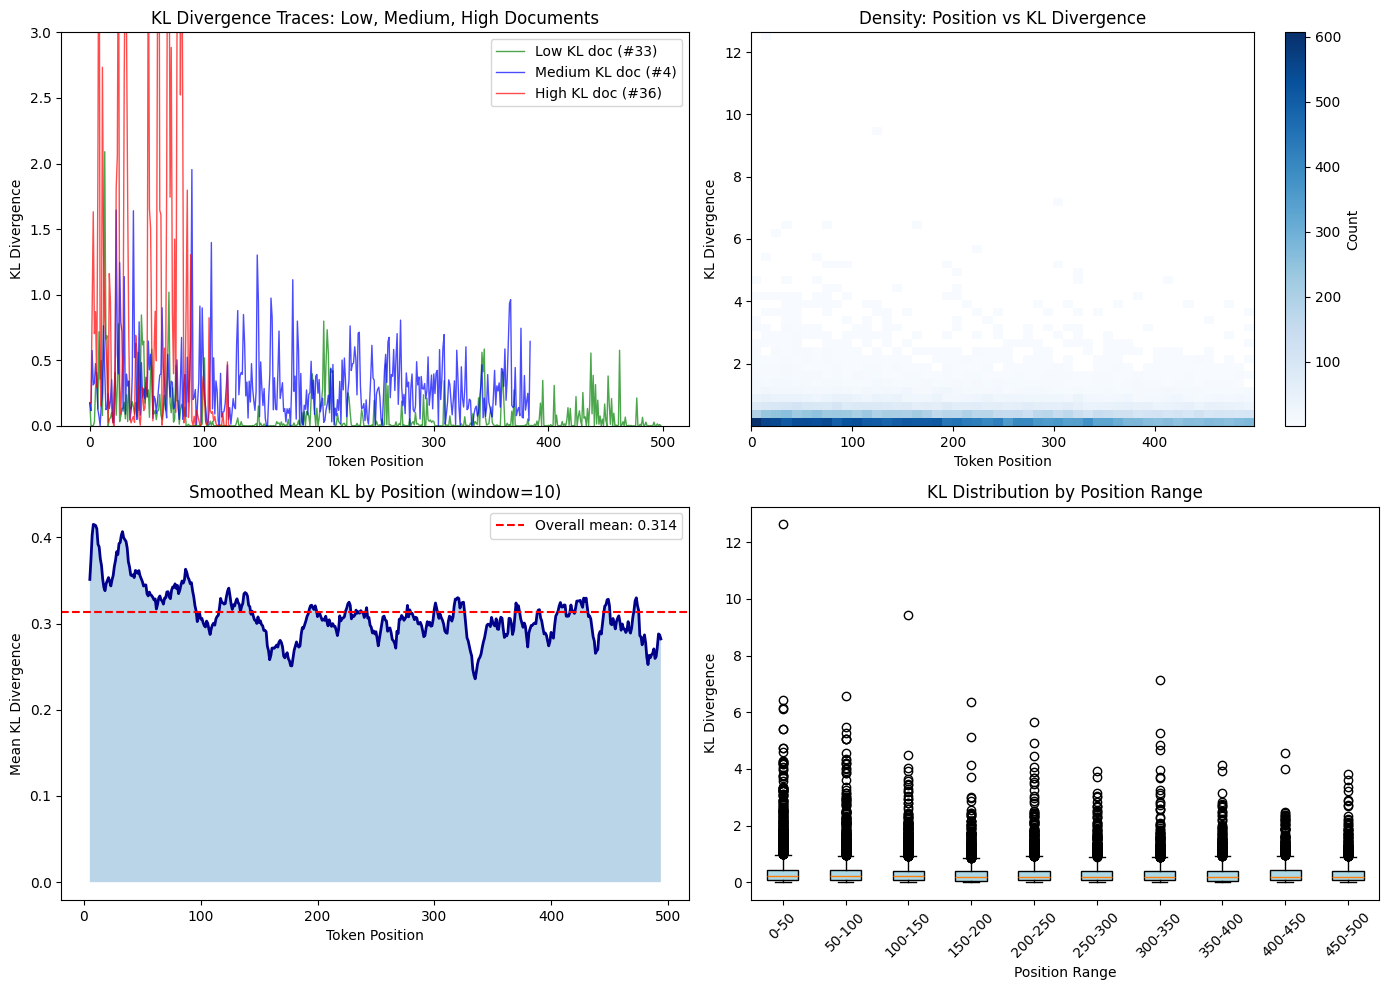

In [99]:
# Better visualization: Show KL divergence traces for select documents
# Pick documents with high, medium, and low average KL

doc_means = df.groupby("batch_idx")["kl_divergence"].mean().sort_values()
low_kl_doc = doc_means.index[0]
mid_kl_doc = doc_means.index[len(doc_means)//2]
high_kl_doc = doc_means.index[-1]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Top left: Line traces for 3 representative documents
ax = axes[0, 0]
for doc_idx, label, color in [(low_kl_doc, "Low KL doc", "green"), 
                               (mid_kl_doc, "Medium KL doc", "blue"),
                               (high_kl_doc, "High KL doc", "red")]:
    doc_data = df[df["batch_idx"] == doc_idx].sort_values("position")
    ax.plot(doc_data["position"], doc_data["kl_divergence"], 
            alpha=0.7, label=f"{label} (#{doc_idx})", color=color, linewidth=1)
ax.set_xlabel("Token Position")
ax.set_ylabel("KL Divergence")
ax.set_title("KL Divergence Traces: Low, Medium, High Documents")
ax.legend()
ax.set_ylim(0, 3)

# Top right: 2D histogram (density plot) - position vs KL
ax = axes[0, 1]
h = ax.hist2d(df["position"], df["kl_divergence"], 
              bins=[50, 50], cmap="Blues", cmin=1)
plt.colorbar(h[3], ax=ax, label="Count")
ax.set_xlabel("Token Position")
ax.set_ylabel("KL Divergence")
ax.set_title("Density: Position vs KL Divergence")

# Bottom left: Rolling average KL by position (smoothed)
ax = axes[1, 0]
window = 10
rolling_kl = df.groupby("position")["kl_divergence"].mean().rolling(window=window, center=True).mean()
ax.plot(rolling_kl.index, rolling_kl.values, color="darkblue", linewidth=2)
ax.fill_between(rolling_kl.index, rolling_kl.values, alpha=0.3)
ax.set_xlabel("Token Position")
ax.set_ylabel("Mean KL Divergence")
ax.set_title(f"Smoothed Mean KL by Position (window={window})")
ax.axhline(y=df["kl_divergence"].mean(), color="red", linestyle="--", 
           label=f"Overall mean: {df['kl_divergence'].mean():.3f}")
ax.legend()

# Bottom right: Box plot by position bins
ax = axes[1, 1]
df["position_bin"] = pd.cut(df["position"], bins=10, labels=False)
position_labels = [f"{int(i*50)}-{int((i+1)*50)}" for i in range(10)]
box_data = [df[df["position_bin"] == i]["kl_divergence"].values for i in range(10)]
bp = ax.boxplot(box_data, labels=position_labels, patch_artist=True)
for patch in bp["boxes"]:
    patch.set_facecolor("lightblue")
ax.set_xlabel("Position Range")
ax.set_ylabel("KL Divergence")
ax.set_title("KL Distribution by Position Range")
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(FIGURES_DIR / "kl_divergence_analysis.png", dpi=150)
plt.show()

# Clean up temp column
df.drop(columns=["position_bin"], inplace=True)

## Summary

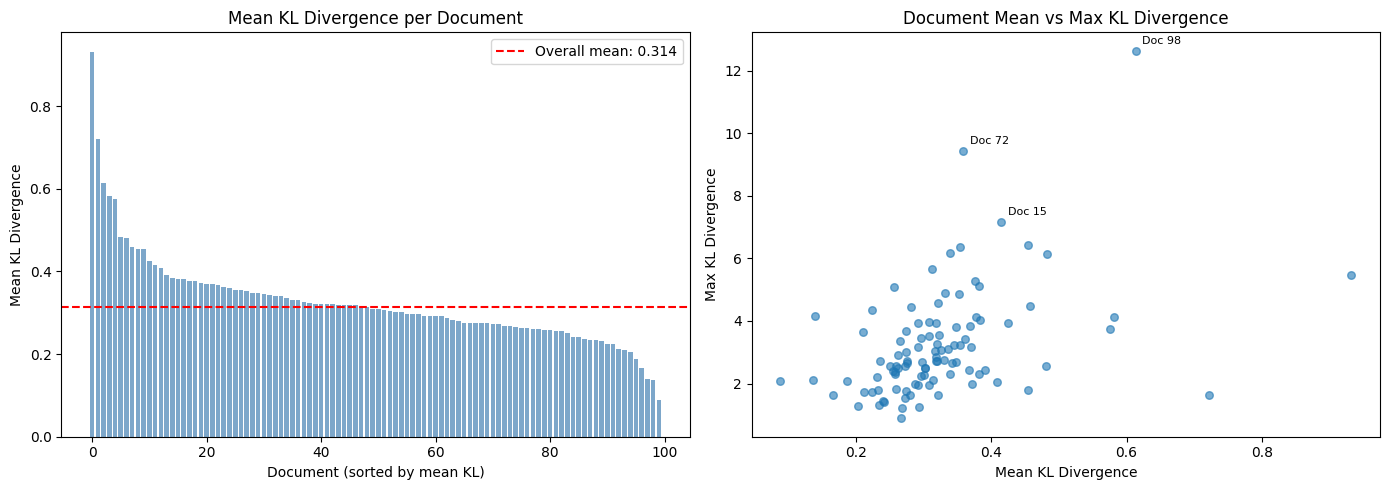


Top 5 documents with highest mean KL divergence:
 batch_idx  mean_kl   std_kl    max_kl
        36 0.931839 1.313252  5.465069
        89 0.721001 0.477922  1.645669
        98 0.613187 1.324776 12.632759
        64 0.581546 0.596082  4.137352
        53 0.575317 0.551866  3.731222


In [100]:
# Per-document statistics: which documents have highest average KL?
doc_stats = df.groupby("batch_idx")["kl_divergence"].agg(["mean", "std", "max"]).reset_index()
doc_stats.columns = ["batch_idx", "mean_kl", "std_kl", "max_kl"]
doc_stats = doc_stats.sort_values("mean_kl", ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot of mean KL per document
axes[0].bar(range(len(doc_stats)), doc_stats["mean_kl"].values, color="steelblue", alpha=0.7)
axes[0].set_xlabel("Document (sorted by mean KL)")
axes[0].set_ylabel("Mean KL Divergence")
axes[0].set_title("Mean KL Divergence per Document")
axes[0].axhline(y=df["kl_divergence"].mean(), color="red", linestyle="--", label=f"Overall mean: {df['kl_divergence'].mean():.3f}")
axes[0].legend()

# Scatter: mean vs max KL per document
axes[1].scatter(doc_stats["mean_kl"], doc_stats["max_kl"], alpha=0.6, s=30)
axes[1].set_xlabel("Mean KL Divergence")
axes[1].set_ylabel("Max KL Divergence")
axes[1].set_title("Document Mean vs Max KL Divergence")

# Annotate top outliers
top_docs = doc_stats.nlargest(3, "max_kl")
for _, row in top_docs.iterrows():
    axes[1].annotate(f"Doc {int(row['batch_idx'])}", 
                     (row["mean_kl"], row["max_kl"]),
                     textcoords="offset points", xytext=(5, 5), fontsize=8)

plt.tight_layout()
plt.savefig(FIGURES_DIR / "kl_per_document.png", dpi=150)
plt.show()

print("\nTop 5 documents with highest mean KL divergence:")
print(doc_stats.head(5).to_string(index=False))

In [101]:
print("=" * 60)
print("SUMMARY")
print("=" * 60)
print(f"""
Models compared:
  - Small: {SMALL_MODEL_NAME}
  - Big: {BIG_MODEL_NAME}

Dataset: {DATASET_NAME}
  - Documents: {df['batch_idx'].nunique()}
  - Total tokens: {len(df):,}
  - Max tokens per doc: {MAX_TOKENS}

KL Divergence Statistics:
  - Mean: {df['kl_divergence'].mean():.4f}
  - Median: {df['kl_divergence'].median():.4f}
  - Max: {df['kl_divergence'].max():.4f}
  - 95th percentile: {df['kl_divergence'].quantile(0.95):.4f}
  - 99th percentile: {df['kl_divergence'].quantile(0.99):.4f}

Output saved to: {OUTPUT_DIR}
""")

SUMMARY

Models compared:
  - Small: pythia-410m
  - Big: pythia-1.4b

Dataset: NeelNanda/pile-10k
  - Documents: 100
  - Total tokens: 34,965
  - Max tokens per doc: 500

KL Divergence Statistics:
  - Mean: 0.3139
  - Median: 0.1979
  - Max: 12.6328
  - 95th percentile: 0.9944
  - 99th percentile: 2.0127

Output saved to: ..\results



## Cleanup

Free GPU memory when done.

In [102]:
del small_model
del big_model
gc.collect()
torch.cuda.empty_cache()
print(f"GPU memory after cleanup: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
print("\n✓ Done!")

GPU memory after cleanup: 0.01 GB

✓ Done!


---

## Next Steps

Now that we understand baseline model differences, we can:

1. **Investigate sycophancy**: Compare base vs chat models on user-framed prompts
2. **Use SAEs**: Extract interpretable features from high-divergence positions
3. **Analyze patterns**: What kinds of tokens/contexts show highest divergence?
4. **Cross-coders**: Use Gemma Scope to find RLHF-specific features